In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def find_diagnose(filename):

    with open(filename, "r") as file:
        lines = file.readlines()

    for line in lines:
        tofind = "# Reason for admission: "
        start = len(tofind)
        if tofind in line:
            diagnose = line[start:].strip()
    if diagnose == "n/a":
        return None
    else: #some signals in the dataset don't have a diagnose
        return diagnose

In [3]:
import wfdb

In [4]:
def multichannel_resample(signal, new_lenght):
    nchs = 15
    resampled_signal = np.zeros((new_lenght, nchs))
    for ch in range(nchs):
        resampled_signal[:, ch] = resample(signal[:, ch], new_lenght)
        #print(resampled_signal[:, ch].shape, resample(signal[:, ch], new_fs).shape)
    return resampled_signal

In [5]:
from scipy.signal import butter, lfilter, iirnotch

def bandpass(lowcut, highcut, order=3, fs = 500):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def notch_filter(cutoff, q, fs=500):
    
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def myfilter(lowcut, highcut, powerline, data):
    
    nchs = 12
    filtered_data = np.zeros_like(data)
    for ch in range(nchs):
        ch_data = data[:, ch]
        b, a = bandpass(lowcut, highcut)   
        x = lfilter(b, a, ch_data)
        f, e = notch_filter(powerline, 30)
        z = lfilter(f, e, x) 
        filtered_data[:, ch] = (x)
    return filtered_data

In [6]:
import os 
import numpy as np 
from scipy.signal import resample

cwd = "C:\\Users\\Utente\\Desktop\\Uni\\ECG Anomaly Detector Clean\\ptb-diagnostic-ecg-database-1.0.0"
patients = [filename for filename in os.listdir(cwd) if "patient" in filename]
y_patients = {}
signals = {}
map_signals = {} #i: patient/record
all_signals = []
notfiltered_signals = []
n = len(patients)
j = 0
for i, patient in enumerate(patients):
    
    print(i+1, "/", n, end="\r")
    patient_dir = cwd + os.sep + patient + os.sep
    records = [filename for filename in os.listdir(patient_dir) if ".dat" in filename]
    y_patients[patient] = {}
    signals[patient] = {}
    for record in records:
        filename = record[:-4] + ".hea"
        hea_file = patient_dir + filename
        diagnose = find_diagnose(hea_file)
        if diagnose is None:
            continue
        y_patients[patient][record] = diagnose
        path_record = patient_dir + record
        signal, fields = wfdb.rdsamp(path_record[:-4])
        signal = multichannel_resample(signal, int(signal.shape[0]/2)) #from 1000hz to 500hz
        notfiltered_signals.append(signal)
        filtered_signal = myfilter(0.5, 100, 50, signal)
        signals[patient][record] = filtered_signal
        all_signals.append(filtered_signal)
        map_signals[j] = patient + "/" + record    
        j += 1
        
#all_signals = np.array(all_signals)
#notfiltered_signals = np.array(notfiltered_signals)

In [7]:
y_all = [diagnose for patient, temp in y_patients.items() for record, diagnose in temp.items()]
uqs, cnts = np.unique(y_all, return_counts = True)
for i, uq in enumerate(uqs):
    cnt = cnts[i]
    print(uq, ":", cnt)

Bundle branch block : 17
Cardiomyopathy : 17
Dysrhythmia : 16
Healthy control : 80
Heart failure (NYHA 2) : 1
Heart failure (NYHA 3) : 1
Heart failure (NYHA 4) : 1
Hypertrophy : 7
Myocardial infarction : 368
Myocarditis : 4
Palpitation : 1
Stable angina : 2
Unstable angina : 1
Valvular heart disease : 6


In [8]:
def binarize(y_int, map_y):

    y_bin = y_int.copy()
    map_bin = {}
    for i, target in map_y.items():
        if target == "Healthy control": #sostituire con NORMAL/CONTROL
            y_bin[y_bin == i] = 0
            map_bin[target] = 0
        else:
            y_bin[y_bin == i] = 1
            map_bin[target] = 1
    return y_bin, map_bin

In [9]:
def prepare_target(y_all):

    y_int = y_all.copy()
    y_int = np.array(y_int)
    map_y = {}
    uqs = np.unique(y_all)
    for i, uq in enumerate(uqs):
        map_y[i] = uq
        y_int[y_int == uq] = i

    y_int = y_int.astype(int)
    y_bin, map_bin = binarize(y_int, map_y)

    return y_int, y_bin, map_y, map_bin


In [10]:
y_int, y_bin, map_y, map_bin = prepare_target(y_all)
y_bin

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
np.unique(y_int, return_counts = True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 array([ 17,  17,  16,  80,   1,   1,   1,   7, 368,   4,   1,   2,   1,
          6], dtype=int64))

In [12]:
map_bin

{'Bundle branch block': 1,
 'Cardiomyopathy': 1,
 'Dysrhythmia': 1,
 'Healthy control': 0,
 'Heart failure (NYHA 2)': 1,
 'Heart failure (NYHA 3)': 1,
 'Heart failure (NYHA 4)': 1,
 'Hypertrophy': 1,
 'Myocardial infarction': 1,
 'Myocarditis': 1,
 'Palpitation': 1,
 'Stable angina': 1,
 'Unstable angina': 1,
 'Valvular heart disease': 1}

In [13]:
#!pip install umap-learn

In [14]:
len(all_signals), len(y_bin)

(522, 522)

In [15]:
from EcgStuffs.src.windows.WindowingUtils import sliding_window
    
windows = []
y_bin_win = []

for i, signal in enumerate(all_signals):
    print("Signal", i+1, "/", len(all_signals), end="\r")
    signal = signal.T
    label = y_bin[i]
    windows_signal = sliding_window(signal[:, 3000:], 2000, 1500) 
    #print()
    for j, window in enumerate(windows_signal):
        #if j+1 in np.arange(1, len(windows_signal), 1000):
            #print("Window", j+1, "/", len(windows_signal), end="\r")
        windows.append(window)
        y_bin_win.append(label)

windows_ptb  = np.array(windows)
y_bin_win = np.array(y_bin_win)

In [16]:
windows_ptb.shape

(18380, 15, 2000)

In [17]:
y_bin_win.shape

(18380,)

In [18]:
def find_diagnose(filename):

    with open(filename, "r") as file:
        lines = file.readlines()

    for line in lines:
        tofind = "# Reason for admission: "
        start = len(tofind)
        if tofind in line:
            diagnose = line[start:].strip()
    if diagnose == "n/a":
        return None
    else: #some signals in the dataset don't have a diagnose
        return diagnose

In [19]:
import wfdb
def multichannel_resample(signal, new_lenght):
    nchs = 15
    resampled_signal = np.zeros((new_lenght, nchs))
    for ch in range(nchs):
        resampled_signal[:, ch] = resample(signal[:, ch], new_lenght)
        #print(resampled_signal[:, ch].shape, resample(signal[:, ch], new_fs).shape)
    return resampled_signal

In [20]:
from scipy.signal import butter, lfilter, iirnotch

def bandpass(lowcut, highcut, order=3, fs = 500):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def notch_filter(cutoff, q, fs=500):
    
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def myfilter(lowcut, highcut, powerline, data):
    
    nchs = 12
    filtered_data = np.zeros_like(data)
    for ch in range(nchs):
        ch_data = data[:, ch]
        b, a = bandpass(lowcut, highcut)   
        x = lfilter(b, a, ch_data)
        f, e = notch_filter(powerline, 30)
        z = lfilter(f, e, x) 
        filtered_data[:, ch] = (x)
    return filtered_data

In [21]:
import pandas as pd

cwd = os.getcwd() + os.sep
path = r"C:\\Users\\Utente\\Desktop\\Uni\\ECG_SR\\data\\1d\\PTBXL\\"
filename = path + "ptbxl_database.csv"
df = pd.read_csv(filename, sep=",", index_col="ecg_id")
df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [22]:
files =  list(df["filename_hr"].values)
noisy_files = []
n = len(files)
for i in range(n):

    print(i , end=" \r")
    row = df.iloc[i, :]
    filenamehr = row["filename_hr"]
    baselinedrift = row["baseline_drift"]
    staticnoise = row["static_noise"]
    electrodesproblems = row["electrodes_problems"]
    burstnoise = row["burst_noise"]
    if isinstance(baselinedrift, str) or isinstance(staticnoise, str)  or isinstance(electrodesproblems, str)  or isinstance(burstnoise, str):
        #print(baselinedrift, type(baselinedrift), staticnoise, type(staticnoise))
        noisy_files.append(filenamehr)
len(noisy_files)

5010

In [23]:
import numpy as np 

files_no_noise = np.setdiff1d(files, noisy_files)
files_no_noise

array(['records500/00000/00002_hr', 'records500/00000/00003_hr',
       'records500/00000/00007_hr', ..., 'records500/21000/21832_hr',
       'records500/21000/21834_hr', 'records500/21000/21836_hr'],
      dtype='<U25')

In [24]:
newdf = df.copy()
for file in noisy_files:
    newdf = newdf[newdf["filename_hr"] != file]
newdf.head(10)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
7,16193.0,54.0,0,NaN,83.0,2.0,0.0,CS-12 E,1984-11-28 13:32:22,"sinusrhythmus linkstyp t abnormal, wahrscheinl...",...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00007_lr,records500/00000/00007_hr
10,9456.0,22.0,1,NaN,56.0,2.0,0.0,CS-12 E,1984-12-12 14:12:46,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00010_lr,records500/00000/00010_hr
12,11031.0,43.0,1,NaN,44.0,2.0,0.0,CS-12 E,1984-12-21 08:02:26,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00012_lr,records500/00000/00012_hr
14,12925.0,19.0,1,NaN,58.0,2.0,0.0,CS-12 E,1985-01-10 11:45:19,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00014_lr,records500/00000/00014_hr
19,11116.0,20.0,0,NaN,85.0,2.0,0.0,CS-12 E,1985-01-23 11:23:00,sinusrhythmus p-verbreiterung,...,True,NaN,NaN,NaN,NaN,NaN,NaN,7,records100/00000/00019_lr,records500/00000/00019_hr
20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,supraventrikulÄre ersatzsystole(n) interponier...,...,True,NaN,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr
21,17102.0,19.0,1,NaN,58.0,2.0,0.0,CS-12 E,1985-01-25 10:31:52,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/00000/00021_lr,records500/00000/00021_hr


In [25]:
seconds = 10
nchs = 15
fs_hr = 500
lenght_hr = fs_hr*seconds

In [26]:
def load_raw_data(df, path):
    data = [] 
    n = len(df.filename_hr)
    for i, f in enumerate(df.filename_hr):
        print(i+1, "/", n, end=" \r")
        signal, meta = wfdb.rdsamp(path+f)
        signal_filter = myfilter(0.5, 100, 50, signal)
        data.append(signal_filter.T)
        del signal
        del signal_filter
    data = np.array(data)
    return data

In [27]:
cleanrecords_hr = newdf["filename_hr"]
data_hr = load_raw_data(newdf, path)

In [28]:
import torch 

n = len(data_hr)#or hr
nchs = 12
data_hr_tensor = torch.zeros((n, nchs, lenght_hr))
for i in range(n):
    print(i+1, "/", n, end=" \r")
    for j in range(nchs):
        temp_data_hr = torch.from_numpy(data_hr[i, j, :])
        data_hr_tensor[i, j, :] = temp_data_hr

In [29]:
import ast 

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

X_hr = load_raw_data(Y, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df_diagnostic = agg_df[agg_df.diagnostic == 1]
agg_df_notdiagnostic = agg_df[agg_df.diagnostic != 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_diagnostic.index:
            tmp.append(agg_df_diagnostic.loc[key].diagnostic_class)
            break
    return list(set(tmp))

def aggregate_subclass(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_diagnostic.index:
            tmp.append(agg_df_diagnostic.loc[key].diagnostic_subclass)
            break
    return list(set(tmp))

def aggregate_nondiagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df_notdiagnostic.index:
            tmp.append(key)
            break
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_subclass'] = Y.scp_codes.apply(aggregate_subclass)
Y['nondiagnostic_class'] = Y.scp_codes.apply(aggregate_nondiagnostic)

In [30]:
uqs, cnts = np.unique(Y['diagnostic_superclass'], return_counts = True)
map_y = {}
j = 0
for i, uq in enumerate(uqs):
    if len(uq) > 0:
        map_y[uq[0]] = j
        j+=1
    cnt = cnts[i]
    print(uq, ": ", cnt)

[] :  411
['CD'] :  2325
['HYP'] :  1308
['MI'] :  5424
['NORM'] :  9514
['STTC'] :  2817


In [31]:
X_test = data_hr_tensor
y_test = list(Y['diagnostic_superclass'].values)
y_test = [y[0] if len(y)>0 else "" for y in y_test]
y_test_bin = [0 if y == "NORM" else 1 for y in y_test]
np.unique(y_test_bin), y_test

(array([0, 1]),
 ['NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'MI',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  '',
  '',
  'NORM',
  '',
  'NORM',
  'STTC',
  '',
  'NORM',
  'NORM',
  'STTC',
  'NORM',
  'STTC',
  'NORM',
  'HYP',
  'NORM',
  'CD',
  'NORM',
  '',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'MI',
  'NORM',
  'CD',
  'NORM',
  'NORM',
  'NORM',
  'CD',
  'NORM',
  'NORM',
  'STTC',
  'CD',
  'MI',
  'NORM',
  'CD',
  'NORM',
  'STTC',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'MI',
  'NORM',
  'CD',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'MI',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'STTC',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'HYP',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'NORM',
  'STTC',
  'MI',


In [32]:
def sliding_window(signal, size=500, stride=500):
    
    windows = []
    #print(signal.shape)
    sig_len = signal.shape[-1]
    win_num = math.ceil((sig_len - size) / stride) + 1
    for i in range(win_num):
        offset = i * stride
        #print(offset, offset + size)
        windows.append((signal[:, offset : offset + size]))
    return windows


def split_windows(data, width = 1500, stride = 1000):
    
    nchs = 15
    windows_data = []
    for i, signal in enumerate(data):
        windows = sliding_window(signal, width, stride = stride)
        for window in windows:
            windows_data.append(window)    
            
    temp = torch.zeros(len(windows_data), 1, nchs, width)
    
    for i, data in enumerate(windows_data):
        temp[i, :, :12, :] = torch.unsqueeze(data[:12], dim = 0)

    windows_data = temp
    return windows_data


In [33]:
def arrange_leads(data):
    col1, col2 = 4, 3

    # Swap columns
    data[:, [col1, col2]] = data[:, [col2, col1]]
    return data

In [34]:
map_y_rev = {value: key for key,value in map_y.items()}
map_y_rev

{0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

In [35]:
import math 
windows_test_hr = []
windows_labels = []
windows_labelsstr = []
signals_clean = []
y_clean = []

device = "cuda" if torch.cuda.is_available() else "cpu"

map_windows = {}
map_labels = {}

j = 0
for i, tensor in enumerate(X_test):

    print(i+1, "/", X_test.shape[0], end=" \r")
    label = y_test_bin[i]
    label_str = y_test[i]
    if label_str == "":
        continue
    else:
        signals_clean.append(tensor)
        y_clean.append(label_str)
        fs = 500
        width = fs*4
        stride = fs*3
        #print(tensor.shape, width, stride)
        tensor = tensor.unsqueeze(dim = 0)
        windows_data = split_windows(tensor, width = width, stride = stride)
        
        map_windows[i] = []
        map_labels[i] = label
        
        for window in windows_data:
            window = arrange_leads(window)
            windows_test_hr.append(window.to(device)) 
            windows_labels.append(label)
            windows_labelsstr.append(map_y[label_str])
            map_windows[i].append(j)
            j += 1

In [36]:
map_y[label_str]

4

In [37]:
windows_test_hr = torch.stack(windows_test_hr)
windows_labels = torch.tensor(windows_labels)
windows_test_hr.shape, windows_labels.shape

(torch.Size([49518, 1, 15, 2000]), torch.Size([49518]))

In [38]:
windows_labels

tensor([0, 0, 0,  ..., 1, 1, 1])

In [39]:
dataset_data = {"PTB-XL": [windows_test_hr, windows_labels], "PTB": [torch.tensor(windows_ptb), torch.tensor(y_bin_win)]}

In [40]:
np.unique(windows_labels)

array([0, 1], dtype=int64)

In [41]:
np.unique(y_bin_win)

array([0, 1])

In [42]:
map_y_final = {0: "NORMAL", 1: "ANOMALOUS"}

 1 / 2
mapping

plotting
 2 / 2
mapping

plotting
 1 / 2
mapping

plotting
 2 / 2
mapping

plotting


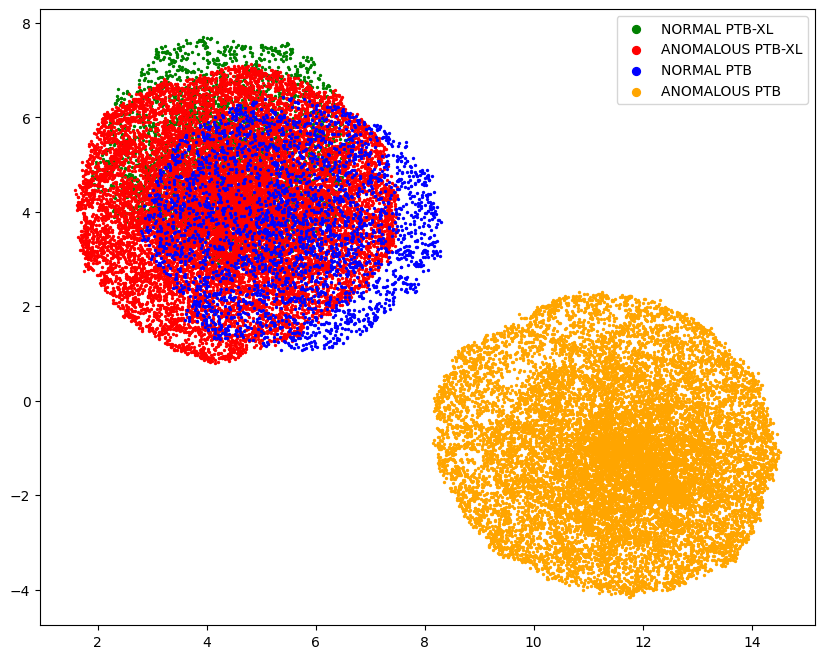

In [47]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt

colors = ["green", "red", "blue", "orange"]

# here we are creating sub plots
figure, ax = plt.subplots(figsize=(10, 8))
points_all = {}

k = 0
for dataset_name, (X, y) in dataset_data.items():
    y = y.cpu().detach().numpy()
    X = X.cpu().detach().numpy()
    uq_y = np.unique(y)
    for i, label in enumerate(uq_y):
    
      print("\r", i+1, "/", len(uq_y), end = "")
    
      idxs = np.argwhere(y_bin_win == label)
      x_to_plot = X[idxs, :, :]
      points = []
    
      for x in x_to_plot:
        proj = x.flatten()
        points.extend([proj])
        del x
    
      points = np.array(points)
      print("\nmapping")
      points = UMAP(n_components=2, n_neighbors=100).fit_transform(points)
      #points = PCA(n_components=2, svd_solver='randomized').fit_transform(points)
      n = len(x_to_plot)
      label_idcs = [i for j in range(n)]
    
      points_all[label] = points[:, :2]
    
      print("\nplotting")
        
      plt.scatter(x=points[:, 0], y=points[:, 1], s=2.0, c=colors[k], label = map_y_final[label]+" "+dataset_name)
      k+=1
plt.legend(markerscale=4)

In [48]:
import gc
gc.collect()

49041